For each practical exercise (TP), please work in groups of two or three. Then, create a **private GitHub repository** and add me (my GitHub is **arthur-75**) to your project. Finally, share the link to your project (or TP) under  [Practical Exercises](https://docs.google.com/spreadsheets/d/1V-YKgHn71FnwjoFltDhWsPJS7uIuAh9lj6SP2DSCvlY/edit?usp=sharing) and make sure to choose your **team name** :-)

# **Variational Autoencoders on CelebA Images**

In [4]:
!pip uninstall numpy
!pip install pandas

Found existing installation: numpy 2.2.3
Uninstalling numpy-2.2.3:
  Would remove:
    /home/antoine/anaconda3/bin/f2py
    /home/antoine/anaconda3/bin/numpy-config
    /home/antoine/anaconda3/lib/python3.12/site-packages/numpy-2.2.3.dist-info/*
    /home/antoine/anaconda3/lib/python3.12/site-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /home/antoine/anaconda3/lib/python3.12/site-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /home/antoine/anaconda3/lib/python3.12/site-packages/numpy.libs/libscipy_openblas64_-6bb31eeb.so
    /home/antoine/anaconda3/lib/python3.12/site-packages/numpy/*
Proceed (Y/n)? ERROR: Operation cancelled by user
^C


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

In [2]:
# --- Hyperparameters ---
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 30
BETA = 2000  # Weight on reconstruction loss
LOAD_MODEL = False
DEVICE = "cuda" #"mps"

## **1: Dataset Preparation and Exploration**

1. **Obtain the CelebA dataset** from Kaggle and **unzip** it into a suitable directory (e.g., `img_align_celeba`).  
   * [CelebFaces Attributes (CelebA) Dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)   
2. **Check the data structure**:  
   * Typically, **ImageFolder** expects subfolders for each class, but here you only have one folder with all images. Adapt your **folder path** accordingly.  
3. **Create a Transform** to:  
   * **Resize** images to 32×32 (smaller dimension for quicker training).  
   * **Convert** to tensors (and optionally normalize if you like).  
4. **Wrap the dataset** in a **DataLoader** with:  

   * `batch_size`, `shuffle=True`.  
   * `drop_last=True` to ensure each batch is exactly the specified size (especially for large images).  
5. **Visualize** a small batch to ensure everything is loading correctly (e.g., using a grid display).

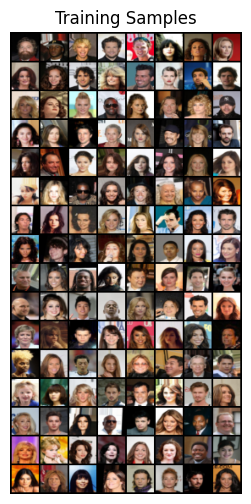

In [4]:
# Path to CelebA images
DATA_PATH = "~/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba"

# Transforms: resize to 32x32 and normalize to [0,1]
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()  # values in [0,1]
])

# Dataset & DataLoader
train_dataset = datasets.ImageFolder(
    root=os.path.dirname(DATA_PATH),  # Folder containing subfolder "img_align_celeba"
    transform=transform
)
# NB: If you have a specific folder structure, adjust accordingly

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

# Utility: show a batch of faces
def show_batch(images, title=""):
    grid_img = utils.make_grid(images, nrow=8)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis("off")
    plt.show()

# Test: Show a sample batch
data_iter = iter(train_loader)
images, _ = next(data_iter)
show_batch(images, title="Training Samples")


Why might you want to **normalize** to a different range (e.g., `[-1, 1]`) instead of `[0, 1]`?

## **2: Model Architecture**

### **2.1 Encoder**

* The encoder uses **convolutional layers** to downsample the image from 32×32 until it’s a small spatial representation.  
* Use **BatchNorm** and **LeakyReLU** activations to stabilize training and handle faces with various lighting conditions.  
* Finally, flatten this representation into a **feature vector** and produce:  
  * **μ**: The mean of the latent distribution.  
  * **log(σ2)**: The log-variance of the latent distribution.

In [5]:
class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.z_dim = z_dim

        self.net = nn.Sequential(
            nn.Conv2d(CHANNELS, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES), #Batch normalisation 
            nn.LeakyReLU(0.2, inplace=True), #activation functuon 

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES), #Batch normalisation 
            nn.LeakyReLU(0.2, inplace=True),  #activation functuon 

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES), #Batch normalisation  
            nn.LeakyReLU(0.2, inplace=True),  #activation functuon 

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Flatten + produce mu & logvar
        # The output shape must be found dynamically
        # Hardcode if you know the shape after 4 conv layers
        # If IMAGE_SIZE=32 & 4 strided layers of stride=2 => output is 2x2
        self.flatten = nn.Flatten()
        # 2x2 out => size is (NUM_FEATURES * 2 * 2) = 128 * 2 * 2
        fc_in_features = NUM_FEATURES * (IMAGE_SIZE // 2**4) ** 2
        self.mu = nn.Linear(fc_in_features, z_dim)
        self.logvar = nn.Linear(fc_in_features, z_dim)

    def forward(self, x):
        x = self.net(x)
        x = self.flatten(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar


### **2.2 Sampling**

* Implement the **reparameterization trick**  
* This allows gradients to flow back through μ and σ, despite sampling being a stochastic process.

In [6]:
class Sampling(nn.Module):
    def forward(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


### **2.3 Decoder**

* Invert the process:  
  1. **Linear** layer maps from latent space RzdimRzdim​ to a flattened feature representation.  
  2. **Reshape** into a small spatial feature map.  
  3. Use **ConvTranspose2d** (also called deconvolution) layers to upsample back to 32×32 images.  
  4. Apply a **Sigmoid** at the end to ensure output pixel values are in \[0,1\]\[0,1\].


In [7]:

class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.z_dim = z_dim

        # Reverse of flatten
        fc_out_features = NUM_FEATURES * (IMAGE_SIZE // 2**4) ** 2
        self.fc = nn.Sequential(
            nn.Linear(z_dim, fc_out_features),
            nn.BatchNorm1d(fc_out_features),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.deconv = nn.Sequential(
            # Reshape => (N, NUM_FEATURES, 2, 2) if 4 strided layers used
            # We'll reshape in forward()

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(NUM_FEATURES, CHANNELS, 3, stride=2, padding=1, output_padding=1),
            # Output: (CHANNELS, 32, 32)
            nn.Sigmoid()  # since we want [0,1] output
        )

    def forward(self, z):
        x = self.fc(z)
        # Reshape -> (N, NUM_FEATURES, 2, 2)
        x = x.view(-1, NUM_FEATURES, (IMAGE_SIZE // 2**4), (IMAGE_SIZE // 2**4))
        x = self.deconv(x)
        return x


Why might we use **BatchNorm** and **LeakyReLU** in the decoder?  
How does the output `ConvTranspose2d` layer ensure the final resolution is 32×32?

### **2.4 All together** 

In [9]:
class VAE(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        self.sampling = Sampling()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.sampling(mu, logvar)
        recon = self.decoder(z)
        return mu, logvar, recon, z


## **3: VAE Loss Function**

**3.1 Reconstruction Loss**

* Either **BCE (binary cross entropy)** or **MSE (mean squared error)**.  
* For faces with continuous pixel intensities, **MSE** often works well, but BCE can be used if values are in \[0,1\]\[0,1\].

**3.2 KL Divergence**

* Encourages the learned distribution q(z∣x)q(z∣x) to be close to a standard normal p(z)p(z).  
* The standard formula is:  
  

* Often scaled by a factor if you want a ββ-VAE (which might help with disentanglement but can reduce reconstruction quality).


In [18]:

def vae_loss_fn(x, recon, mu, logvar, beta=BETA):
    """
    x, recon: shape (N, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    mu, logvar: shape (N, Z_DIM)
    """
    # 1) Reconstruction Loss (MSE or BCE)
    # - Following your TF code => MSELoss with a BETA factor
    recon_loss = F.mse_loss(recon, x, reduction="sum") 

    # 2) KL Divergence
    # kl_loss ~ -0.5 * sum(1 + logvar - mu^2 - exp(logvar)) 
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    recon_loss = recon_loss / x.size(0)
    #kl = kl_loss = kl / x.size(0)

    total_loss = recon_loss + kl_loss * (beta / x.size(0))

    return total_loss, recon_loss, kl_loss

if LOAD_MODEL and os.path.exists("./models/vae.pt"):
    print("Loading existing model...")
    model.load_state_dict(torch.load("./models/vae.pt"))

## **4: Training Loop**

1. **Initialize** the VAE and **optimizer** (e.g., Adam with a suitable learning rate).  
2. **Iterate over epochs**:  
   1. Set the model to **train** mode.  
   2. For each batch:  
      * Send images to the GPU/CPU.  
      * Forward pass: encode → reparameterize → decode → get reconstructed images.  
      * Compute **VAE loss** \= recon loss \+ KL divergence (optionally scaled by β).  
      * **Backpropagate** and **update weights**.  
   3. Print or log the **average loss** per epoch.


In [25]:
model = VAE(Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
for epoch in range(EPOCHS):
    model.train()
    total_loss_val = 0.0
    total_rec_val = 0.0
    total_kl_val = 0.0

    for batch_idx, (x, _) in enumerate(train_loader):  # replace xxx with train_loader
        x = x.to(DEVICE)
        optimizer.zero_grad()  # replace xxx with zero_grad()

        mu, logvar, recon, _ = model(x)
        loss, rec_loss, kl_loss = vae_loss_fn(x, recon, mu, logvar, BETA)  # fill in x, recon, mu, logvar, BETA

        loss.backward()  # replace xxx with backward()
        optimizer.step()  # replace xxx with step()

        total_loss_val += loss.item()
        total_rec_val += rec_loss.item()
        total_kl_val += kl_loss.item()

    avg_loss = total_loss_val / len(train_loader)
    avg_rec = total_rec_val / len(train_loader)
    avg_kl = total_kl_val / len(train_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f} | Recon: {avg_rec:.4f} | KL: {avg_kl:.4f}")
torch.save(model.state_dict(), "VAEmodel_state_dict.pth")

Epoch [1/30] | Loss: 396.4183 | Recon: 228.2257 | KL: 10.7643
Epoch [2/30] | Loss: 234.7385 | Recon: 226.8057 | KL: 0.5077
Epoch [3/30] | Loss: 232.7480 | Recon: 226.7338 | KL: 0.3849
Epoch [4/30] | Loss: 231.0529 | Recon: 226.6842 | KL: 0.2796
Epoch [5/30] | Loss: 230.2560 | Recon: 226.6857 | KL: 0.2285
Epoch [6/30] | Loss: 229.6264 | Recon: 226.6174 | KL: 0.1926
Epoch [7/30] | Loss: 228.7443 | Recon: 226.6271 | KL: 0.1355
Epoch [8/30] | Loss: 228.4957 | Recon: 226.6047 | KL: 0.1210
Epoch [9/30] | Loss: 228.0484 | Recon: 226.5965 | KL: 0.0929
Epoch [10/30] | Loss: 228.1255 | Recon: 226.5952 | KL: 0.0979
Epoch [11/30] | Loss: 227.6761 | Recon: 226.5805 | KL: 0.0701
Epoch [12/30] | Loss: 227.6099 | Recon: 226.5597 | KL: 0.0672
Epoch [13/30] | Loss: 227.1156 | Recon: 226.5703 | KL: 0.0349
Epoch [14/30] | Loss: 227.4091 | Recon: 226.5595 | KL: 0.0544
Epoch [15/30] | Loss: 226.8010 | Recon: 226.5624 | KL: 0.0153
Epoch [16/30] | Loss: 226.9510 | Recon: 226.5518 | KL: 0.0255
Epoch [17/30] | 


#### You must at least run one epoch and then load this pre-trained model:

In [ ]:
# Load state dictionariespath= "path"model.load_state_dict(torch.load(path, map_location=DEVICE))model.eval()

## **5: Generating and Saving Images**

1. **Save** the model periodically or once training completes.  
2. **Sample** random latent vectors z∼N(0,I)z∼N(0,I).  
3. **Decode** them into face images.  
4. Display or save the generated images to track progress.

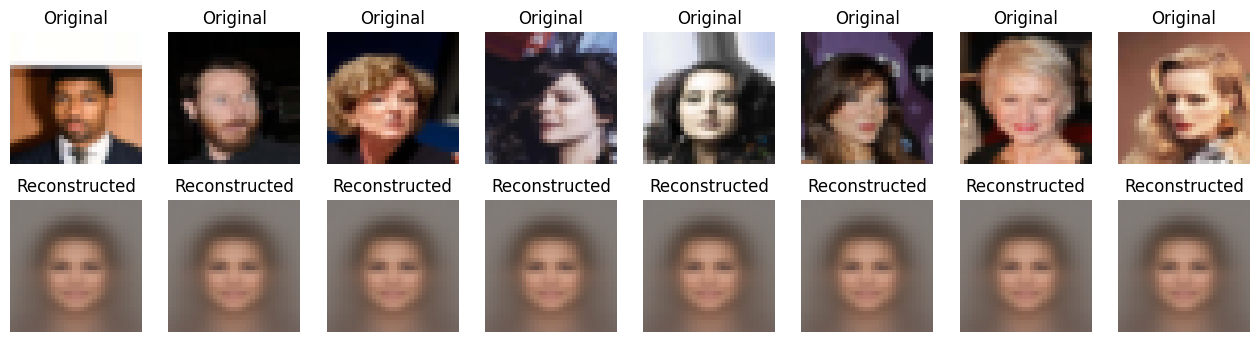

In [26]:
# Save the final model
os.makedirs("./models", exist_ok=True)
torch.save(model.state_dict(), "./models/vae_face.pt")

model.eval()

# Take a small batch to reconstruct
data_iter = iter(train_loader)
images, _ = next(data_iter)
images = images[:8].to(DEVICE)

with torch.no_grad():
    mu, logvar, recon,_ = model(images)

# Visualize original vs. reconstructions
def show_reconstructions(orig, recon):
    """
    Show original (top row) and reconstructions (bottom row).
    """
    n = orig.size(0)
    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i+1)
        plt.imshow(orig[i].permute(1,2,0).cpu().numpy())
        plt.title("Original")
        plt.axis("off")

    for i in range(n):
        # Recon
        plt.subplot(2, n, n+i+1)
        plt.imshow(recon[i].permute(1,2,0).detach().cpu().numpy())
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

show_reconstructions(images, recon)

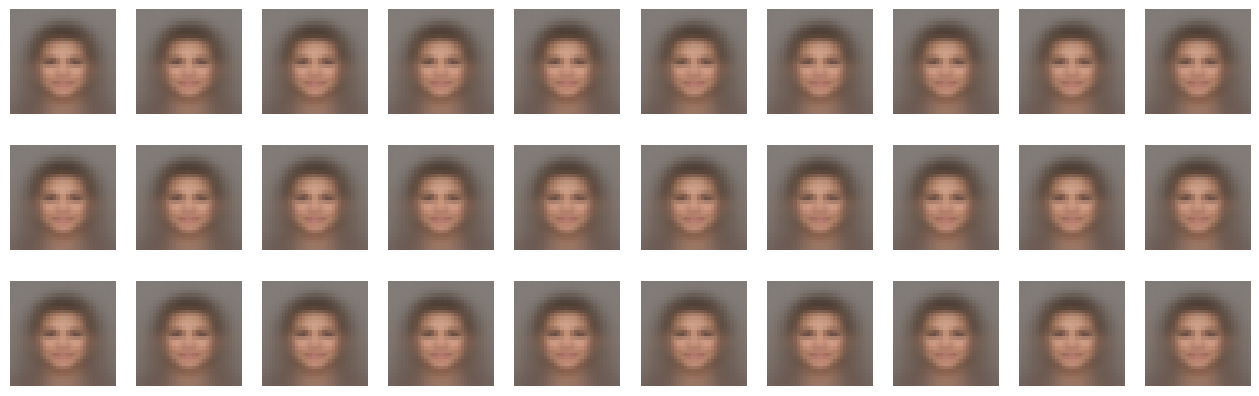

In [27]:
model.eval()

grid_width, grid_height = 10, 3
z_sample = torch.randn((grid_width*grid_height, Z_DIM)).to(DEVICE)

with torch.no_grad():
    recon = model.decoder(z_sample).detach()

# Plot the generated images
def show_generated(recon, w=grid_width, h=grid_height):
    recon = recon.cpu()
    fig = plt.figure(figsize=(16, 5))
    for i in range(w*h):
        ax = fig.add_subplot(h, w, i+1)
        ax.axis("off")
        ax.imshow(recon[i].permute(1,2,0).numpy())
    plt.show()

show_generated(recon)


## **6: Next Steps and Experiments (optional)**

* **Experiment** with:  
  1. Larger or smaller **image sizes** (e.g., 64×64) for better detail.  
  2. Different **latent dimensions** (Zdim=100 vs. Zdim=200).  
  3. Various **activations** (e.g., ReLU vs. LeakyReLU).  
  4. Adjusting **β** to see how it affects the **quality** of generated faces and the **structure** of the latent space.

## **(Nothing to do just play with it)**

## **Step 7: Building a Custom Dataset with Attributes**

Create a **custom PyTorch Dataset** that:

1. Reads attributes from a **CSV file** (e.g., `list_attr_celeba.csv`).  
2. Loads the corresponding **image** for each entry.  
3. Returns a **(image, label)** pair, where `label` indicates the presence or absence of an attribute (e.g., “Blond\_Hair”).

### **7.1 Read the CSV**

* **Load the CSV** using a library like **pandas** (`pd.read_csv(...)`).  
* Inspect the column names. Often, the CSV has an **"image\_id"** column plus columns for each attribute (e.g., `Blond_Hair` is \-1 or \+1).

### **7.2 Implement a `__getitem__` Method**

1. **Index** into the DataFrame to get the row of interest.  
2. Retrieve the **image filename** and construct the **full path** (using `os.path.join(...)`).  
3. Load the image with **PIL** (`Image.open(...)`) and **convert** to `"RGB"`.  
4. Apply **transforms** (resize, to-tensor, normalize).  
5. Extract the **attribute** value (e.g., `row["Blond_Hair"]`):  
   * If it’s `-1`, you could convert it to `0`; if it’s `+1`, convert to `1`, or keep them as is if you want to differentiate positive vs. negative explicitly.

### **7.3 Create a DataLoader**

* Use the **custom Dataset** in a PyTorch `DataLoader` with parameters like `batch_size`, `shuffle`, etc.  
* Test with a single batch to confirm the shape of `(images, labels)`:  
  * `images` should be `(B, 3, 32, 32)` if color images are resized to 32×32.  
  * `labels` should be `(B,)` if it’s just a single attribute.

In [28]:

# Suppose you have a CSV with attributes:
# /app/data/celeba-dataset/list_attr_celeba.csv
# Convert -1/1 => 0/1 to be more standard if needed.

# Load attributes
# Using pandas:
attributes = pd.read_csv("img_align_celeba/list_attr_celeba.csv")
print(attributes.columns)

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


In [37]:

LABEL = "Blond_Hair" or "Eyeglasses"  # example

# We now want to create a data loader that yields (image, label)
# Quick approach: we can build a custom dataset. This is a conceptual snippet.

# Example minimal custom dataset
from PIL import Image

class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, img_folder, attr_csv, label=LABEL, transform=None):
        self.transform = transform
        self.img_folder = img_folder
        self.df = pd.read_csv(attr_csv)
        self.label = label
        # adjust if needed => if original images are named 000001.jpg, etc.

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Typically, row["image_id"] might hold the filename, e.g. 1.jpg or something
        file_name = row["image_id"]  # adapt to match your CSV
        path = os.path.join(self.img_folder, file_name)
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label_val = row[self.label]
        # Convert -1 => 0, +1 => 1 if needed
        return image, label_val

# Then you create a DataLoader:
label_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])
"""ArithmeticError
label_dataset = CelebADataset(img_folder, 
                              "img_align_celeba/list_attr_celeba.csv",
                              label=LABEL,
                              transform=label_transform)
label_loader = DataLoader(label_dataset, batch_size=BATCH_SIZE, shuffle=True)
"""
base_path = os.path.expanduser("~/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2")
img_folder = os.path.join(base_path, "img_align_celeba/img_align_celeba")
csv_path = os.path.join(base_path, "list_attr_celeba.csv")

label_dataset = CelebADataset(
    img_folder=img_folder, 
    attr_csv=csv_path,
    label=LABEL,
    transform=label_transform
)
label_loader = DataLoader(label_dataset, batch_size=BATCH_SIZE, shuffle=True)



# For attribute vector extraction, you'd:
# 1) Accumulate latent codes for positives and negatives
# 2) Subtract negative mean from positive mean
# 3) That difference is your attribute direction in latent space


## **8: Extracting an Attribute Vector in Latent Space**

Identify how the **attribute** (e.g. “Blond\_Hair”) is **encoded** in the VAE’s **latent space** by:

1. Gathering latent codes for **positive** samples (attribute \= \+1) and for **negative** samples (attribute \= \-1).  
2. **Subtracting** the mean latent code of the negatives from the mean latent code of the positives to get a **direction vector**.

### **8.1 Sample Latent Codes from the Dataset**

1. **Iterate** over batches from the labeled DataLoader.  
2. **Forward** each batch through the **VAE** to obtain the latent representation (whether that’s `z` directly or you compute `z = reparameterize(mu, logvar)`).  
3. Split your batch into **positives** (`attribute=+1`) and **negatives** (`attribute=-1`).  
4. Keep a **running sum** of the latent vectors for each group and a count of how many have been added.

### **8.2 Compute Mean Vectors**

* Once you have the sums and counts for both **positive** and **negative** latents, compute their **means**:

![][image1]

### **8.3 Extract the Attribute Direction**

* **Attribute Vector** \=   
* **Normalize** it if you want a unit vector. For example: 




* This vector represents the **direction** in latent space that corresponds to transitioning from **negative** to **positive examples** of the attribute.


In [38]:

import torch
import numpy as np

def get_vector_from_label(loader, vae, embedding_dim, label_name="Attribute", max_samples=10000):
    """
    Replicates the logic from 'get_vector_from_label' in Torch.
    
    loader: a PyTorch DataLoader yielding (images, labels) or (images, attribute).
            We assume attribute is in {-1, +1}.
    vae:    a VAE model with .encoder => returns (mu, logvar, z) or .forward => (mu, logvar, recon).
    embedding_dim: dimension of the latent space (z-dim).
    label_name: just for printing, e.g. "Blond_Hair".
    max_samples: how many positive or negative samples to gather before we stop.
    
    Returns: A direction vector in latent space (np.ndarray, shape=(embedding_dim,)).
    """
    device = next(vae.parameters()).device
    vae.eval()

    # Accumulators
    current_sum_POS = np.zeros(embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(embedding_dim, dtype="float32")

    current_vector = np.zeros(embedding_dim, dtype="float32")
    current_dist = 0.0

    print(f"label: {label_name}")
    print("images : POS move : NEG move : distance : Δ distance")

    # We'll iterate over the loader, collecting latents
    for images, attributes in loader:
        images = images.to(device)
        attributes = attributes.to(device)

        with torch.no_grad():
            recon, mu, logvar, z = vae(images)  # Suppose vae(...) => (mu, logvar, recon) or (mu, logvar, z)
            # If your VAE only returns (mu, logvar, recon), remove z => or do z = model.sampling(mu, logvar)
            # We'll assume the third output is z. Adjust as needed.
        
        # Move from GPU to CPU and to numpy
        z_np = z.detach().cpu().numpy()  # shape (N, embedding_dim)
        attr_np = attributes.detach().cpu().numpy()  # shape (N, )

        # Filter out positives/negatives
        mask_pos = np.where(attr_np == 1)[0]
        mask_neg = np.where(attr_np == -1)[0]

        z_POS = z_np[mask_pos]
        z_NEG = z_np[mask_neg]

        # Update partial sums
        if len(z_POS) > 0:
            current_sum_POS += np.sum(z_POS, axis=0)
            old_mean_POS = current_mean_POS.copy()
            current_n_POS += len(z_POS)
            current_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(current_mean_POS - old_mean_POS)
        else:
            movement_POS = 0.0

        if len(z_NEG) > 0:
            current_sum_NEG += np.sum(z_NEG, axis=0)
            old_mean_NEG = current_mean_NEG.copy()
            current_n_NEG += len(z_NEG)
            current_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(current_mean_NEG - old_mean_NEG)
        else:
            movement_NEG = 0.0

        # Current vector is difference
        current_vector = current_mean_POS - current_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(f"{current_n_POS}    : {movement_POS:.3f}    : {movement_NEG:.3f}    : {new_dist:.3f}    : {dist_change:.3f}")

        current_dist = new_dist

        # Stopping conditions
        # 1) Enough samples
        if current_n_POS >= max_samples and current_n_NEG >= max_samples:
            pass
        # 2) Movement is small
        if (movement_POS + movement_NEG) < 0.08 and new_dist > 1e-8:
            current_vector /= new_dist
            print(f"Found the {label_name} vector")
            break

    return current_vector  # np array
feature_vec = get_vector_from_label(label_loader, model, embedding_dim=Z_DIM, label_name=LABEL)


label: Blond_Hair
images : POS move : NEG move : distance : Δ distance
17    : 3.496    : 1.236    : 3.608    : 3.608
44    : 2.683    : 0.843    : 2.393    : -1.215
68    : 1.270    : 0.555    : 1.966    : -0.427
87    : 0.797    : 0.388    : 1.734    : -0.232
113    : 0.816    : 0.321    : 1.504    : -0.230
133    : 0.499    : 0.259    : 1.395    : -0.110
151    : 0.414    : 0.207    : 1.233    : -0.161
171    : 0.396    : 0.185    : 1.125    : -0.109
191    : 0.347    : 0.152    : 1.061    : -0.064
207    : 0.289    : 0.145    : 1.018    : -0.043
228    : 0.290    : 0.136    : 0.969    : -0.049
243    : 0.266    : 0.121    : 0.911    : -0.058
260    : 0.213    : 0.111    : 0.906    : -0.005
285    : 0.243    : 0.089    : 0.872    : -0.034
303    : 0.209    : 0.090    : 0.831    : -0.041
322    : 0.195    : 0.088    : 0.771    : -0.059
343    : 0.178    : 0.080    : 0.760    : -0.011
359    : 0.179    : 0.082    : 0.737    : -0.024
380    : 0.183    : 0.075    : 0.700    : -0.037
409


## **9: Using the Attribute Vector**

Once you have an **attribute vector** (e.g., “Blond\_Hair”, “Eyeglasses”), you can **modify** new or existing images in latent space:

### **9.1 Adding the Vector to Images**

1. Take a small batch of images.  
2. **Encode** them to get latent codes z.  
3. **Add** multiples of the attribute vector V attr​ to each code:   
   Z′ \= z \+ α ⋅ V attr​   
   for a range of αα values (like \-4 to \+4).  
4. **Decode** each ′z′ to reconstruct an image with more or less of that attribute (e.g., hair color changing).

## **![][image2]**

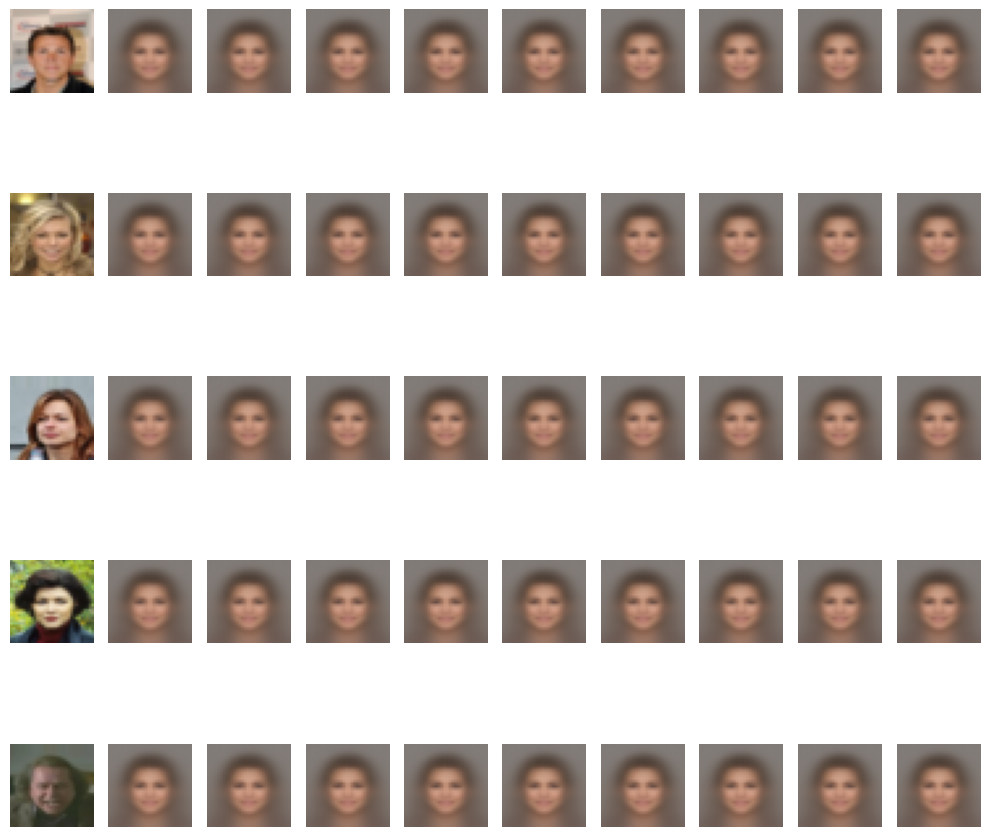

In [39]:

import matplotlib.pyplot as plt

def add_vector_to_images(loader, vae, feature_vec, factors=None):
    """
    Replicates 'add_vector_to_images' in PyTorch.
    
    loader: yields (images, labels).
    vae: a trained VAE with .encoder(...) => (mu, logvar, z) or .forward(...) => ...
    feature_vec: an np.array of shape (embedding_dim,).
    factors: list of multiples to add to the latent code. e.g. [-4, -3, -2, -1, 0, 1, 2, 3, 4].
    """
    if factors is None:
        factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

    device = next(vae.parameters()).device
    vae.eval()

    # Take one batch from loader
    images, _ = next(iter(loader))  # or loader.__iter__() if repeated
    images = images.to(device)

    with torch.no_grad():
        _, mu, logvar, z = vae(images)

    # We'll show 5 images
    n_to_show = min(5, images.size(0))

    fig = plt.figure(figsize=(len(factors) + 1, n_to_show * 2))
    counter = 1

    for i in range(n_to_show):
        # Original image
        orig_img = images[i].detach().cpu().permute(1,2,0).numpy()
        ax = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        counter += 1
        ax.axis("off")
        ax.imshow(orig_img)
        
        # For each factor
        base_z = z[i].detach().cpu().numpy()  # shape (embedding_dim,)
        for f in factors:
            changed_z = base_z + feature_vec * f
            changed_z_torch = torch.from_numpy(changed_z).unsqueeze(0).float().to(device)  # (1, z_dim)

            with torch.no_grad():
                recon = vae.decoder(changed_z_torch)  # shape (1, C, H, W)
                recon_img = recon[0].detach().cpu().permute(1,2,0).numpy()

            ax = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            counter += 1
            ax.axis("off")
            ax.imshow(recon_img)

    plt.tight_layout()
    plt.show()
# 2) Add vector to images
add_vector_to_images(label_loader, model, feature_vec)


### **9.2 Morph Faces Between Two Latent Codes**

* Pick **two different images** A and B.  
* Encode them into zA​ and zB​.  
* **Interpolate** in latent space with:z(α)=(1−α) z.A  +  α z.B, α∈\[0,1\]  
* Decode each intermediate code to see a **smooth morph** from face A to face B.

![][image3]

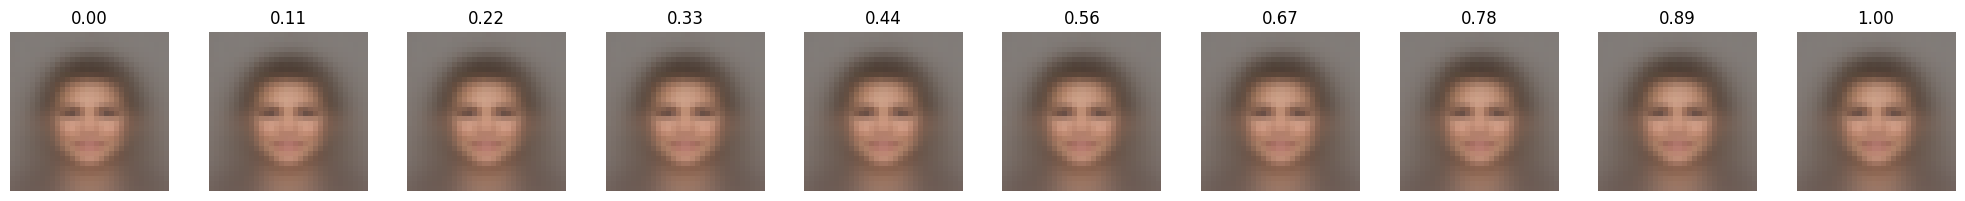

In [40]:

def morph_faces(loader, vae, steps=10):
    """
    Replicates 'morph_faces' logic in PyTorch.
    
    loader: yields (images, labels).
    vae: trained VAE.
    steps: how many interpolation steps to show.
    """
    device = next(vae.parameters()).device
    vae.eval()

    # Take one batch, pick first 2 images
    images, _ = next(iter(loader))
    images = images[:2].to(device)  # shape (2, C, H, W)
    if images.size(0) < 2:
        print("Not enough images in the batch to morph.")
        return

    with torch.no_grad():
        _,mu, logvar, z = vae(images)  # shape (2, z_dim)
    
    zA = z[0].detach().cpu().numpy()
    zB = z[1].detach().cpu().numpy()

    factors = np.linspace(0, 1, steps)
    plt.figure(figsize=(2*steps, 2))

    # show image A on the far left
    idx = 1
    for alpha in factors:
        inter_z = zA * (1 - alpha) + zB * alpha
        inter_z_torch = torch.from_numpy(inter_z).unsqueeze(0).float().to(device)
        with torch.no_grad():
            recon = vae.decoder(inter_z_torch)  # shape (1, C, H, W)
        recon_img = recon[0].detach().cpu().permute(1,2,0).numpy()

        ax = plt.subplot(1, steps, idx)
        idx += 1
        ax.imshow(recon_img)
        ax.set_title(f"{alpha:.2f}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()
# 3) Morph two faces
morph_faces(label_loader, model, steps=10)